### Fourier Single-Pixel Imaging with Phase-Shifting Sinusoid Illumination
#### Author: Ritz Ann Aguilar
#### Date: October 1, 2018
##### Based on Zibang Zhang et al. paper

In [11]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import time
import glob

types = ('*.bmp','*.png','*.jpg','*.tif','*.gif')

In [13]:
def im2double(im):
    min_val = np.min(im.ravel())
    max_val = np.max(im.ravel())
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

In [ ]:
def PathMat2OrderMat(PathMat, mRow, nCol, PathStr):
    [ OrderMatFilename ] = getOrderMatFilename( mRow, nCol, PathStr )
    
    if exist(OrderMatFilename, 'file')                                     
        load(OrderMatFilename);                                            
        disp('The path matrix exists.');                                   
    else
        disp('Generating the path matrix...');                             

        Mask = getHalfSpecMask(mRow, nCol);                               

        PathMatMasked = PathMat .* Mask;                                   
        PathMatMaskedArr = reshape(PathMatMasked, [length(PathMatMasked(:)) 1]);
        [Val, Ind] = sort(PathMatMaskedArr,  'ascend');                    
                                                                           
        FirstNonZeroElement = find(Val~=0);                                
        FirstNonZeroElementInd = FirstNonZeroElement(1);                   
        Ind = Ind(FirstNonZeroElementInd:end);                             

        nPoint = length(Ind);                                              
        OrderMat = zeros(nPoint, 2);                                       

        for iPoint in range(nPoint):                                          
            OrderMat(iPoint,2) = floor(Ind(iPoint) / mRow) + 1       
            OrderMat(iPoint,1) = mod(Ind(iPoint)- 1, mRow) + 1            

        print('Generating the path matrix...Done!')

        save(OrderMatFilename, 'OrderMat')
        
        return OrderMat

In [43]:
def getOrderMatrix(mRow, nCol, SamplingPath):
    if mRow > nCol:
        nPixel  = mRow
    else:
        nPixel = nCol
    
    if SamplingPath == 'spiral':
        PathMat = np.rot90(spiral(nPixel),2)                                  
    elif SamplingPath == 'circular':
        PathMat = CircularPath(nPixel, nPixel, floor(nPixel/2)+1, floor(nPixel/2)+1, ceil(ceil(nPixel/2)*sqrt(2)))
    elif SamplingPath == 'diamond':
        PathMat = ZigzagFourier(nPixel)
        
    LeftMargin = np.floor((nPixel - nCol)/2)                                
    RightMargin = np.floor((nPixel - nCol)/2)
    TopMargin = np.floor((nPixel - mRow)/2)
    BottomMargin = np.floor((nPixel - mRow)/2)
    
    PathMat = PathMat(TopMargin + 1 : TopMargin + mRow, LeftMargin + 1 : LeftMargin + nCol)
    OrderMat = PathMat2OrderMat(PathMat, mRow, nCol, SamplingPath)

SyntaxError: invalid syntax (<ipython-input-43-3ae5d9288151>, line 19)

([], <a list of 0 Text yticklabel objects>)

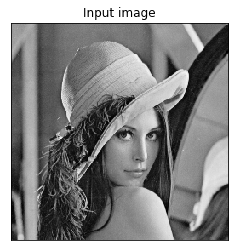

In [21]:
SW_NOISE = 0                       # 0: noiseless, 1: noisy

## Parameters
nStepPS = 4                        # n-step phase-shifting (3 or 4 only)
Phaseshift = 90                    # phase shift (90 if 4, 90 or 120 if 3)
Amplitude = 1                      # amplitude of sine pattern
SpectralCoverage = 0.2             # sampling ratio (0 to 1)
SamplingPath = 'spiral'            # spiral, diamond, circular

## Get input image
InputImg = im2double(plt.imread('graylena256.bmp'))  
plt.imshow(InputImg,cmap='gray')
plt.title('Input image')
plt.xticks([])
plt.yticks([])

In [37]:
[mRow, nCol] = np.shape(InputImg)
fx = np.arange(0,nCol-1,1)/nCol
fy = np.arange(0,mRow-1,1)/mRow
[fxMat, fyMat] = np.meshgrid(fx, fy) 

fxMat = np.fft.fftshift(fxMat)
fyMat = np.fft.fftshift(fyMat)

In [ ]:
OrderMat = getOrderMat(mRow, nCol, SamplingPath)                    # generate sampling path in Fourier domain
[nCoeft,tmp] = size(OrderMat)                                            
nCoeft = round(nCoeft * SpectralCoverage)                               

InitPhaseArr = getInitPhaseArr(nStepPS, Phaseshift)                      
IntensityMat = zeros(mRow, nCol, nStepPS)                                

RealFourierCoeftList = getRealFourierCoeftList(mRow, nCol)                

if SW_NOISE
    ReponseNoise = np.rand(nCoeft * nStepPS) * 2                       # add noise

## Main loop for simulating time-varying patterns illumination and single-pixel detection
start_time = time.time                                                                       
                                                                           
for iCoeft in range(nCoeft):                                                      
    iRow = OrderMat(iCoeft,1)                                            
    jCol = OrderMat(iCoeft,2)                                             
    
    fx = fxMat(iRow,jCol)                                                
    fy = fyMat(iRow,jCol)                                                

    IsRealCoeft = existVectorInMat([iRow jCol], RealFourierCoeftList) 
    
     for iStep in range(StepPS)                                                
        if IsRealCoeft == 1 && iStep > 2                                   
            if nStepPS == 3                                                
                IntensityMat(iRow,jCol,iStep) = IntensityMat(iRow,jCol,2)
            elif nStepPS == 4                                                
                IntensityMat(iRow,jCol,iStep) = 0                      
            continue                                
            
        [Pattern] = getFourierPattern(Amplitude, mRow, nCol, fx, fy, InitPhaseArr(iStep))
        IntensityMat(iRow, jCol, iStep) = sum(sum(InputImg .* Pattern))

end_time = time.time                                                                    

In [ ]:
## Show and save results
[img, spec] = getFSPIReconstruction( IntensityMat, nStepPS, Phaseshift );  

figure, imshow(img); 
caxis([0 1]); 
axis image; 
colormap gray; 
title('Reconstructed Img');
figure, specshow(spec)     # show Fourier spectrum in a log scale

PSNR = psnr(img, InputImg);                                                
SSIM = ssim(img, InputImg);
RMSE = rmse(InputImg, img);

fprintf('PNSR = %f\nSSIM = %f\nRMSE = %f\n', PSNR, SSIM, RMSE);

In [ ]:
## Saving results
ErrorImg = InputImg - img;                                                           
figure, imagesc(ErrorImg); axis image; colormap jet; colorbar; title('error image'); 

TrueSpec = fftshift(fft2(InputImg));                                       

SpecAbsDiff = abs(spec) - abs(TrueSpec);                                   
SpecRealDiff = real(spec) - real(TrueSpec);                                
SpecImagDiff = imag(spec) - imag(TrueSpec);                                

figure, imagesc(SpecAbsDiff); axis image; colormap gray; title('spec abs diff'); colorbar;   
figure, imagesc(SpecRealDiff); axis image; colormap gray; title('spec real diff'); colorbar;
figure, imagesc(SpecImagDiff); axis image; colormap gray; title('spec imag diff'); colorbar;

ResultFolderName = sprintf('[%s]FSI_Simulation_mRow=%d_nCol=%d_nStep=%d_PS=%d', TimeStamp, mRow, nCol, nStepPS, Phaseshift);

mkdir(ResultFolderName);
ResultFileName = 'results.mat';
ResultFilePath = fullfile(ResultFolderName, ResultFileName);
save(ResultFilePath);